## Kaggle 데이터 셋 colab에서 불러오기
1. 내계정 고유 API Token 다운 받기
2. 다운 받은 API Token 업로드 하기
3. json 파일 옮겨주기
4. json 파일 제대로 업로드 됐는지 확인
5. 본인이 참가한 모든 대회 보기
6. 데이터 셋 다운로드 받기 - link는 해당 대회의 'Data'에 있음
7. (다운로드 된 것들 보기)
8. (필요시 압축 풀기)

다행히 [한국어로 된 가이드](https://medium.com/hyunjulie/%EC%BA%90%EA%B8%80%EA%B3%BC-%EA%B5%AC%EA%B8%80-colab-%EC%97%B0%EA%B2%B0%ED%95%B4%EC%A3%BC%EA%B8%B0-6a274f6de81d)가 있어서 쉽게 참고하였습니다. 이 방식으로 수행한다면 별도로 google drive를 마운트 하는 작업 없이 kaggle data를 load할 수 있습니다.

### ※ 내계정 고유 API Token 다운 받기
My Account > API > Create New API Token 버튼을 누르게 되면 `kaggle.json`파일이 다운로드 됩니다.

In [2]:
# API Token 다운받기

In [3]:
# 다운받은 API Token 업로드 하기
!pip install kaggle
from google.colab import files
files.upload()

# !ls -1ha kaggle.json # 확인용

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"mongnyonglee","key":"1f9b2690a6d131428bb2bba9507233af"}'}

In [4]:
# json 파일 옮겨주기
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Permission Warning 이 일어나지 않도록 
!chmod 600 ~/.kaggle/kaggle.json

# 본인이 참가한 모든 대회 보기 
!kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
contradictory-my-dear-watson                   2030-07-01 23:59:00  Getting Started     Prizes         91           False  
gan-getting-started                            2030-07-01 23:59:00  Getting Started     Prizes        196           False  
tpu-getting-started                            2030-06-03 23:59:00  Getting Started  Knowledge        449           False  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       3052           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      24403            True  
house-prices-advanced-regression-techniques    2030-01-01 00:00:00  Getting Started  Knowledge       6038           False  
connectx

In [5]:
# 데이터셋 다운로드 받기 - 링크는 그 대회 'Data'에 있음
# 형식 : ! copy API link
! kaggle datasets download -d netflix-inc/netflix-prize-data

netflix-prize-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
# 다운로드 된 것들 다 보기 
!ls

 combined_data_1.txt  'kaggle (1).json'         probe.txt
 combined_data_2.txt   kaggle.json	        qualifying.txt
 combined_data_3.txt   movie_titles.csv         README
 combined_data_4.txt   netflix-prize-data.zip   sample_data


In [7]:
# 필요하면 압축 풀기 
# !unzip netflix-prize-data.zip

Archive:  netflix-prize-data.zip
replace README? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace combined_data_1.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace combined_data_2.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [8]:
# 압축 해제 된 것들 다 보기 
!ls

 combined_data_1.txt  'kaggle (1).json'         probe.txt
 combined_data_2.txt   kaggle.json	        qualifying.txt
 combined_data_3.txt   movie_titles.csv         README
 combined_data_4.txt   netflix-prize-data.zip   sample_data


---
# Project Start!

## 목차
- 목표 설정
- Data manipulation
    - Data loading
    - Data viewing
    - Data cleaning
    - Data slicing
    - Data mapping
- 추천 알고리즘 모델 구축
    - Collaborative Filtering
    - 피어슨 R 상관관계 이용

## 목표
데이터로 부터 정보를 얻은 후, <u>자신의 또는 다른 사람들의 행동 패턴을 기반</u>으로 적합한 컨텐츠 추천

## Data manipulation
### Data loading
각 데이터 파일 (combined_data_1 ~ 4.txt)은 아래 칼럼들을 포함하고 있음:
- Movie ID
- Customer ID
- Rating (1 to 5)
- Date of Ratings

다른 파일에는 `Movie ID`를 이용하여 해당 컨텐츠 출시일, 이름, 등을 향후에 mapping할 수 있음.

In [9]:
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns

!pip install surprise # 추천 시스템 구현 라이브러리
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
sns.set_style("darkgrid")

우선 combined_data_1.txt 파일을 불러와 보겠습니다.

In [10]:
# 데이터 불러오기

# Skip date
df1 = pd.read_csv('combined_data_1.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])

df1['Rating'] = df1['Rating'].astype(float)

print('Dataset 1 shape: {}'.format(df1.shape))
print('-Dataset examples-')
print(df1.iloc[::5000000, :])

Dataset 1 shape: (24058263, 2)
-Dataset examples-
          Cust_Id  Rating
0              1:     NaN
5000000   2560324     4.0
10000000  2271935     2.0
15000000  1921803     2.0
20000000  1933327     3.0


나머지 데이터 파일도 읽도록 하겠습니다. (여기서는 간단한 실험 확인을 위해 생략하도록 하겠습니다.

In [11]:
# df2 = pd.read_csv('combined_data_2.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
# df3 = pd.read_csv('combined_data_3.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
# df4 = pd.read_csv('combined_data_4.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])


# df2['Rating'] = df2['Rating'].astype(float)
# df3['Rating'] = df3['Rating'].astype(float)
# df4['Rating'] = df4['Rating'].astype(float)

# print('Dataset 2 shape: {}'.format(df2.shape))
# print('Dataset 3 shape: {}'.format(df3.shape))
# print('Dataset 4 shape: {}'.format(df4.shape))

combined_data_1 ~ 4.txt까지의 데이터를 통합하는 작업입니다. (생략)

In [12]:
# load less data for speed

df = df1
#df = df1.append(df2)
#df = df.append(df3)
#df = df.append(df4)

df.index = np.arange(0,len(df))
print('Full dataset shape: {}'.format(df.shape))
print('-Dataset examples-')
print(df.iloc[::5000000, :])

Full dataset shape: (24058263, 2)
-Dataset examples-
          Cust_Id  Rating
0              1:     NaN
5000000   2560324     4.0
10000000  2271935     2.0
15000000  1921803     2.0
20000000  1933327     3.0


### Data viewing
다음으로 자료의 기술통계 정보를 보도록 하겠습니다.

현재는 수치화시킬 수 있는 정보가 `Rating`칼럼 밖에 없으므로 `Rating`에 대해서만 시각화 해주었습니다.

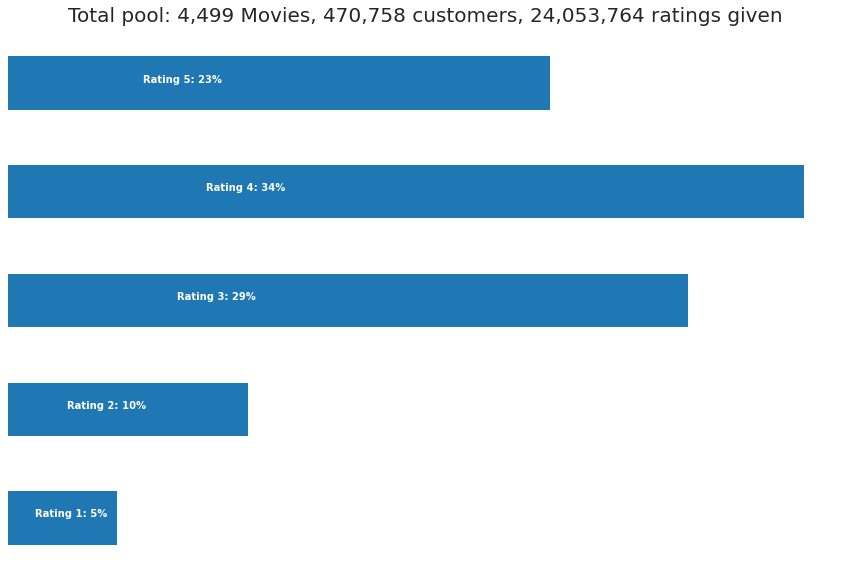

In [13]:
p = df.groupby('Rating')['Rating'].agg(['count'])

# get movie count
movie_count = df.isnull().sum()[1]

# get customer count
cust_count = df['Cust_Id'].nunique() - movie_count

# get rating count
rating_count = df['Cust_Id'].count() - movie_count

ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Total pool: {:,} Movies, {:,} customers, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=20)
plt.axis('off')

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')

50%가 넘는 데이터가 대부분 3 또는 4점 Rating에 분포되어있으며, 전체의 85%정도가 3점이상인 걸 확인 할 수 있습니다.

### Data cleaning
되게 신기한 데이터 구조라고 생각한게 `Movie ID`는 combined_data에 Rating이 NaN값으로 되어 있는 `Customer_ID`가 `Movie ID`고, 그 다음 행부터 다음 NaN값까지가 그 영화에 대한 Rating이라고 합니다.

따라서, NaN값을 찾고 `Movie ID`라는 3번째 칼럼을 생성하여 해당 영화를 Rating 한 Customer의 행에 Movie ID를 부여하는 과정을 거쳐야 됩니다.

하지만 for문으로 단순히 loop과정을 반복하는 것은 매우 비효율적이기 때문에 (Movie ID가 1부터 연속 정수값을 가진다는 가정하에) numpy array를 사용하므로서 더 효율적으로 처리를 할 수 있습니다.

In [14]:
df_nan = pd.DataFrame(pd.isnull(df.Rating))
df_nan = df_nan[df_nan['Rating'] == True]
df_nan = df_nan.reset_index()

movie_np = []
movie_id = 1

for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
    # numpy approach
    temp = np.full((1,i-j-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1

# Account for last record and corresponding length
# numpy approach
last_record = np.full((1,len(df) - df_nan.iloc[-1, 0] - 1),movie_id)
movie_np = np.append(movie_np, last_record)

print('Movie numpy: {}'.format(movie_np))
print('Length: {}'.format(len(movie_np)))


Movie numpy: [1.000e+00 1.000e+00 1.000e+00 ... 4.499e+03 4.499e+03 4.499e+03]
Length: 24053764


In [15]:
# remove those Movie ID rows
df = df[pd.notnull(df['Rating'])]

df['Movie_Id'] = movie_np.astype(int)
df['Cust_Id'] = df['Cust_Id'].astype(int)
print('-Dataset examples-')
print(df.iloc[::5000000, :])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


-Dataset examples-
          Cust_Id  Rating  Movie_Id
1         1488844     3.0         1
5000996    501954     2.0       996
10001962   404654     5.0      1962
15002876   886608     2.0      2876
20003825  1193835     2.0      3825


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


### Data slicing
데이터가 이제 한 칼럼이 추가되면서 좀 더 커졌습니다. 그래서 효율적인 커널 사용을 하여 데이터의 질을 높이기 위해 데이터 양을 줄이는 다음과 같은 과정을 거쳤습니다:
- Rating 수가 너무 적은 (상대적으로 덜 유명한) Movie 제거
- Rating을 많이 주지 않은 (상대적으로 활발하지 않은) Customer 제거

이렇게 비인기 Movie, 비활성 Customer를 제거하는 방법으로 상당한 효율성 증대를 이룰 수 있었습니다.

> 다시 해석: Having above benchmark will have significant improvement on efficiency, since those unpopular movies and non-active customers still occupy same volumn as those popular movies and active customers in the view of matrix (NaN still occupy space). 

어떻게 실행되었는지 다음 코드를 봅시다.
> 내 생각: Rating 수가 적은 영화를 삭제하는 것은 좋지만, 비활성 고객의 Rating을 함부로 제거하는 것은 옳은 가? 추천 시스템을 평가 기반으로 구축한다면 모를까 같은 취향의 사람들을 군집화하여 추천해야 한다면 아무리 적은 Rating을 자주 안하는 사람 정보라도 참고해야 되지 않을 까?

In [16]:
f = ['count','mean']

df_movie_summary = df.groupby('Movie_Id')['Rating'].agg(f)
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = round(df_movie_summary['count'].quantile(0.7),0)
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index

print('Movie minimum times of review: {}'.format(movie_benchmark))

df_cust_summary = df.groupby('Cust_Id')['Rating'].agg(f)
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(0.7),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print('Customer minimum times of review: {}'.format(cust_benchmark))

Movie minimum times of review: 1799.0
Customer minimum times of review: 52.0


확실히 전과 비교하면 학습 데이터의 양이 줄어든 모습을 볼 수 있습니다. (좋은 질의 데이터를 확보하였다고 해석됨)

In [17]:
print('Original Shape: {}'.format(df.shape))
df = df[~df['Movie_Id'].isin(drop_movie_list)]
df = df[~df['Cust_Id'].isin(drop_cust_list)]
print('After Trim Shape: {}'.format(df.shape))
print('-Data Examples-')
print(df.iloc[::5000000, :])

Original Shape: (24053764, 3)
After Trim Shape: (17337458, 3)
-Data Examples-
          Cust_Id  Rating  Movie_Id
696        712664     5.0         3
6932490   1299309     5.0      1384
13860273   400155     3.0      2660
20766530   466962     4.0      3923


이제는 정리된 데이터를 pivot화 시킵시다. 그리고 추천시스템을 위한 거대한 행렬에 입력하도록 합시다.

In [18]:
df_p = pd.pivot_table(df,values='Rating',index='Cust_Id',columns='Movie_Id')

print(df_p.shape)


(143458, 1350)


In [19]:
# Below is another way I used to sparse the dataframe...doesn't seem to work better

#Cust_Id_u = list(sorted(df['Cust_Id'].unique()))
#Movie_Id_u = list(sorted(df['Movie_Id'].unique()))
#data = df['Rating'].tolist()
#row = df['Cust_Id'].astype('category', categories=Cust_Id_u).cat.codes
#col = df['Movie_Id'].astype('category', categories=Movie_Id_u).cat.codes
#sparse_matrix = csr_matrix((data, (row, col)), shape=(len(Cust_Id_u), len(Movie_Id_u)))
#df_p = pd.DataFrame(sparse_matrix.todense(), index=Cust_Id_u, columns=Movie_Id_u)
#df_p = df_p.replace(0, np.NaN)

### Data mapping
이제 `movie_titles.csv` 파일로 해당 데이터의 정보와 연결시킬 작업을 준비합니다.

In [20]:
df_title = pd.read_csv('movie_titles.csv', encoding = "ISO-8859-1", header = None, names = ['Movie_Id', 'Year', 'Name'])
df_title.set_index('Movie_Id', inplace = True)
print (df_title.head(10))

            Year                          Name
Movie_Id                                      
1         2003.0               Dinosaur Planet
2         2004.0    Isle of Man TT 2004 Review
3         1997.0                     Character
4         1994.0  Paula Abdul's Get Up & Dance
5         2004.0      The Rise and Fall of ECW
6         1997.0                          Sick
7         1992.0                         8 Man
8         2004.0    What the #$*! Do We Know!?
9         1991.0      Class of Nuke 'Em High 2
10        2001.0                       Fighter


---
> 여기서부터는 Colab RAM 제한 때문에 제대로 된 진행을 하지 못했습니다. 더 효율적인 RAM사용 법을 연구해 봐야겠습니다.
## 추천시스템 구축
모든 데이터가 정제되고 정리되었습니다. 이제 바로 추천 시스템을 위한 모델을 구축 해봅시다.

## Collaborative Filtering
[협업 기반 필터링](https://en.wikipedia.org/wiki/Collaborative_filtering)(다른 사용자 데이터를 기반으로 추천해주는 알고리즘)을 평가해봅시다.

In [1]:
reader = Reader()

# get just top 100K rows for faster run time
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']][:], reader)
#data.split(n_folds=3)

svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'])

NameError: ignored

예시) Customer_ID가 783514인 이용자가 지금까지 만족(Rating 5점)했던 영화 목록입니다.

In [ ]:
df_785314 = df[(df['Cust_Id'] == 785314) & (df['Rating'] == 5)]
df_785314 = df_785314.set_index('Movie_Id')
df_785314 = df_785314.join(df_title)['Name']
print(df_785314)

783514 이용자가 좋아할 법한 영화 를 추출해봅시다.

In [ ]:
user_785314 = df_title.copy()
user_785314 = user_785314.reset_index()
user_785314 = user_785314[~user_785314['Movie_Id'].isin(drop_movie_list)]

# getting full dataset
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']], reader)

trainset = data.build_full_trainset()
svd.fit(trainset)

user_785314['Estimate_Score'] = user_785314['Movie_Id'].apply(lambda x: svd.predict(785314, x).est)

user_785314 = user_785314.drop('Movie_Id', axis = 1)

user_785314 = user_785314.sort_values('Estimate_Score', ascending=False)
print(user_785314.head(10))

### 피어슨 R 상관관계를 이용한 추천
모든 영화에 대해 회귀 상관계수를 구한 뒤 가장 높은 상관계수를 가진 영화들을 추출하는 방법입니다.

In [ ]:
def recommend(movie_title, min_count):
    print("For movie ({})".format(movie_title))
    print("- Top 10 movies recommended based on Pearsons'R correlation - ")
    i = int(df_title.index[df_title['Name'] == movie_title][0])
    target = df_p[i]
    similar_to_target = df_p.corrwith(target)
    corr_target = pd.DataFrame(similar_to_target, columns = ['PearsonR'])
    corr_target.dropna(inplace = True)
    corr_target = corr_target.sort_values('PearsonR', ascending = False)
    corr_target.index = corr_target.index.map(int)
    corr_target = corr_target.join(df_title).join(df_movie_summary)[['PearsonR', 'Name', 'count', 'mean']]
    print(corr_target[corr_target['count']>min_count][:10].to_string(index=False))

예시1) 'What the #$*! Do We Know!?' 영화에 대한 비슷한 상관관계를 가진 영화들입니다.

In [ ]:
recommend("What the #$*! Do We Know!?", 0)

예시2) 'X2: X-Men United' 영화에 대한 비슷한 상관관계를 가진 영화들입니다.

In [ ]:
recommend("X2: X-Men United", 0)